In [1]:
import pandas as pd
import seaborn as sea
import numpy as np
import matplotlib.pyplot as plt
import math
import warnings

## Lendo csv's

In [14]:
BH = pd.read_csv("/home/gabriel/_Gabriel/Estudo/5 Período/Meteorologia/Trabalho-Ventos/Dados/Selected/dados_BELOHORIZONTE_83587_H_2000-01-01_2019-12-31.csv", sep = ";")
UB = pd.read_csv("/home/gabriel/_Gabriel/Estudo/5 Período/Meteorologia/Trabalho-Ventos/Dados/Selected/dados_UBERLANDIA_A507_H_2002-12-17_2019-12-31.csv", sep = ";")
BM = pd.read_csv("/home/gabriel/_Gabriel/Estudo/5 Período/Meteorologia/Trabalho-Ventos/Dados/Selected/dados_BELEM_A201_H_2003-01-19_2019-12-31.csv", sep = ";")
QX = pd.read_csv("/home/gabriel/_Gabriel/Estudo/5 Período/Meteorologia/Trabalho-Ventos/Dados/Selected/dados_QUIXERAMOBIM_A325_H_2007-07-08_2019-12-31.csv", sep = ";")
TM = pd.read_csv("/home/gabriel/_Gabriel/Estudo/5 Período/Meteorologia/Trabalho-Ventos/Dados/Selected/dados_TRESMARIAS_A528_H_2006-08-24_2019-12-31.csv", sep = ";")
df_list = ['Belo Horizonte', 'Uberlândia', 'Belém', 'Quixeramobim', 'Três Marias']

In [15]:
def sepYear(data):
    corte = data[-4:]
    return int(corte)

def sepMonth(data):
    corte = data[3:5]
    return int(corte)

def sepDay(data):
    corte = data[:2]
    return int(corte)

def virgPont(data):
    subs = data.replace(',','.')
    return subs

## Criando colunas de dia - mês - ano

In [16]:
def cols_DMA(usina):
    usina['year'] = usina['Data Medicao'].apply(sepYear)
    usina['month'] = usina['Data Medicao'].apply(sepMonth)
    usina['day'] = usina['Data Medicao'].apply(sepDay)
    return usina

## Deletando anos menores que 2010

In [17]:
def csv_adapt(usina):
    usina = cols_DMA(usina)
    usina = usina.where(usina['year']>=2010).dropna()
    usina['VENTO, VELOCIDADE HORARIA(m/s)'] = usina['VENTO, VELOCIDADE HORARIA(m/s)'].apply(virgPont)
    usina['u10'] = pd.to_numeric(usina['VENTO, VELOCIDADE HORARIA(m/s)'])
    usina = usina.drop(columns=['VENTO, VELOCIDADE HORARIA(m/s)'])
    return usina

In [18]:
csv_adapt(BH)

,Data Medicao,Hora Medicao,year,month,day,u10
10959,01/01/2010,0.0,2010.0,1.0,1.0,1.6
10960,01/01/2010,1200.0,2010.0,1.0,1.0,3.0
10961,01/01/2010,1800.0,2010.0,1.0,1.0,2.6
10962,02/01/2010,0.0,2010.0,1.0,2.0,2.1
10963,02/01/2010,1200.0,2010.0,1.0,2.0,2.1
...,...,...,...,...,...,...
21910,30/12/2019,1200.0,2019.0,12.0,30.0,1.1
21911,30/12/2019,1800.0,2019.0,12.0,30.0,1.5
21912,31/12/2019,0.0,2019.0,12.0,31.0,1.3
21913,31/12/2019,1200.0,2019.0,12.0,31.0,1.6


In [19]:
def media_turno(usina, turno, z0):
    # Faz a média dependendo do turno escolhido e retorna 2 objetos: o DataFrame de média mensal pro turno
    #                                                              e o valor de uTAL numa variável
    usina = csv_adapt(usina)
    
    if turno == 'diurno':
        usina = usina.where((usina['Hora Medicao']>=600) & (usina['Hora Medicao']<=1800)).dropna()
        media = usina.groupby(by='month').mean()
        media['u_tal'] = 0.41 * media['u10'] / (math.log10(10/z0))
        return media
    
    if turno == 'noturno':
        usina = usina.mask((usina['Hora Medicao']>=600) & (usina['Hora Medicao']<=1800)).dropna()
        media = usina.groupby(by='month').mean()
        media['u_tal'] = 0.41 * media['u10'] / (math.log10(10/z0))
        return media

In [86]:
def calc_u130(usina, turno):
    # Essa função por si só já chama todas as outras necessárias para o cálculo da média u130 e retorna um DataFrame com os meses no index
    
    if usina == 'Belo Horizonte':
        z0 = 3
        media = media_turno(BH, turno, z0)
        media['u130'] = (media['u_tal'] * (math.log10(130/z0))) / 0.41
        media['turno'] = turno
    elif usina == 'Uberlândia':
        z0 = 2
        media = media_turno(UB, turno, z0)
        media['u130'] = (media['u_tal'] * (math.log10(130/z0))) / 0.41
        media['turno'] = turno
    elif usina == 'Belém':
        z0 = 2
        media = media_turno(BM, turno, z0)
        media['u130'] = (media['u_tal'] * (math.log10(130/z0))) / 0.41
        media['turno'] = turno
    elif usina == 'Quixeramobim':
        z0 = 0.02
        media = media_turno(QX, turno, z0)
        media['u130'] = (media['u_tal'] * (math.log10(130/z0))) / 0.41
        media['turno'] = turno
    elif usina == 'Três Marias':
        z0 = 0.1
        media = media_turno(TM, turno, z0)
        media['u130'] = (media['u_tal'] * (math.log10(130/z0))) / 0.41
        media['turno'] = turno
    else:
        warnings.warn('please inform the usin so z0 value can be determined')
    return media

In [115]:
mediaD_Quixeramobim_u130 = calc_u130('QX', 'diurno').to_csv('D:/_Gabriel/Estudo/UFF/5 Período/Meteorologia/Trabalho-Ventos/generated_CSVs/medias/u130/mediaD_Quixeramobim_u130.csv')
mediaN_Quixeramobim_u130 = calc_u130('QX', 'noturno').to_csv('D:/_Gabriel/Estudo/UFF/5 Período/Meteorologia/Trabalho-Ventos/generated_CSVs/medias/u130/mediaN_Quixeramobim_u130.csv')

mediaD_BeloHorizonte_u130 = calc_u130('BH', 'diurno').to_csv('D:/_Gabriel/Estudo/UFF/5 Período/Meteorologia/Trabalho-Ventos/generated_CSVs/medias/u130/mediaD_BeloHorizonte_u130.csv')
mediaN_BeloHorizonte_u130 = calc_u130('BH', 'noturno').to_csv('D:/_Gabriel/Estudo/UFF/5 Período/Meteorologia/Trabalho-Ventos/generated_CSVs/medias/u130/mediaN_BeloHorizonte_u130.csv')

mediaD_Uberlandia_u130 = calc_u130('UB', 'diurno').to_csv('D:/_Gabriel/Estudo/UFF/5 Período/Meteorologia/Trabalho-Ventos/generated_CSVs/medias/u130/mediaD_Uberlandia_u130.csv')
mediaN_Uberlandia_u130 = calc_u130('UB', 'noturno').to_csv('D:/_Gabriel/Estudo/UFF/5 Período/Meteorologia/Trabalho-Ventos/generated_CSVs/medias/u130/mediaN_Uberlandia_u130.csv')

mediaD_Belem_u130 = calc_u130('BM', 'diurno').to_csv('D:/_Gabriel/Estudo/UFF/5 Período/Meteorologia/Trabalho-Ventos/generated_CSVs/medias/u130/mediaD_Belem_u130.csv')
mediaN_Belem_u130 = calc_u130('BM', 'noturno').to_csv('D:/_Gabriel/Estudo/UFF/5 Período/Meteorologia/Trabalho-Ventos/generated_CSVs/medias/u130/mediaN_Belem_u130.csv')

mediaD_TresMarias_u130 = calc_u130('TM', 'diurno').to_csv('D:/_Gabriel/Estudo/UFF/5 Período/Meteorologia/Trabalho-Ventos/generated_CSVs/medias/u130/mediaD_TresMarias_u130.csv')
mediaN_TresMarias_u130 = calc_u130('TM', 'noturno').to_csv('D:/_Gabriel/Estudo/UFF/5 Período/Meteorologia/Trabalho-Ventos/generated_CSVs/medias/u130/mediaN_TresMarias_u130.csv')


In [87]:
mediaD = calc_u130('Quixeramobim', 'diurno')
#mediaD['turno'] = 'diurno'
mediaN = calc_u130('Quixeramobim', 'noturno')
#mediaN['turno'] = 'noturno'

In [88]:
mediaN

,Hora Medicao,year,day,u10,u_tal,u130,turno
month,,,,,,,
1.0,1095.171495,2014.211455,15.418248,2.152381,0.326968,3.040731,noturno
2.0,1093.880774,2014.361627,14.824714,1.669641,0.253635,2.358750,noturno
3.0,1103.973277,2014.632208,15.163854,1.312588,0.199395,1.854331,noturno
4.0,1106.717268,2014.193169,15.484250,1.006907,0.152959,1.422487,noturno
5.0,1093.720417,2014.360997,16.654150,1.092016,0.165888,1.542723,noturno
6.0,1089.084828,2014.504409,15.472788,1.173943,0.178334,1.658464,noturno
7.0,1090.201085,2014.600702,16.340249,1.421673,0.215966,2.008438,noturno
8.0,1090.613083,2014.498973,16.004400,2.027574,0.308008,2.864413,noturno
9.0,1091.969846,2014.540806,15.201901,3.026024,0.459683,4.274952,noturno


In [89]:
tst = mediaD#.drop(['Hora Medicao','year','u10','day','u_tal'], axis=1)
tst2 =  mediaN#.drop(['Hora Medicao','year','u10','day','u_tal'], axis=1)
pd.concat([tst,tst2])

,Hora Medicao,year,day,u10,u_tal,u130,turno
month,,,,,,,
1.0,1203.881597,2014.194918,15.450712,1.642390,0.249495,2.320253,diurno
2.0,1202.095111,2014.347190,14.848021,1.407050,0.213745,1.987781,diurno
3.0,1218.496787,2014.667784,15.523610,1.164823,0.176948,1.645579,diurno
4.0,1213.229329,2014.225585,15.236505,1.230546,0.186932,1.738428,diurno
5.0,1202.610334,2014.384284,16.720936,1.352207,0.205413,1.910302,diurno
6.0,1200.076982,2014.502694,15.505004,1.549551,0.235392,2.189096,diurno
7.0,1200.269978,2014.603672,16.338823,1.815497,0.275792,2.564805,diurno
8.0,1199.602287,2014.501864,15.995526,2.099503,0.318935,2.966029,diurno
9.0,1207.586207,2014.517241,15.380902,2.673289,0.406099,3.776633,diurno


<AxesSubplot:>

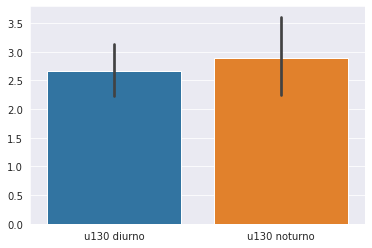

In [69]:
sea.barplot(data = tst)

In [120]:
def plot_bar(usina, turno=None):
    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(16,7))
    sea.set_style('darkgrid')
    
    if turno == None:
        mediaD = calc_u130(usina, 'diurno')
        mediaN = calc_u130(usina, 'noturno')
        mediaF = pd.concat([mediaD,mediaN])
        sea.barplot(x = mediaF.index, y = mediaF['u130'], hue=mediaF['turno'], orient='v')
    else:
        mediaF = calc_u130(usina, turno)
        sea.barplot(x = mediaF.index, y = mediaF['u130'], orient='v', palette = 'Blues_d')
        ax.set_title('Média Mensal de u130 '+ turno + ' em ' + usina , size = 20, pad = 9)
        
    ax.set_xlabel('Mês', fontdict={'fontsize': 15})
    ax.set_ylabel('Magnitude do Vento (m/s)', fontdict={'fontsize': 13})
    #plt.savefig('D:/_Gabriel/Estudo/UFF/5 Período/Meteorologia/Trabalho-Ventos/images/bars/u130_' + usina + '_' + turno + '.jpg')

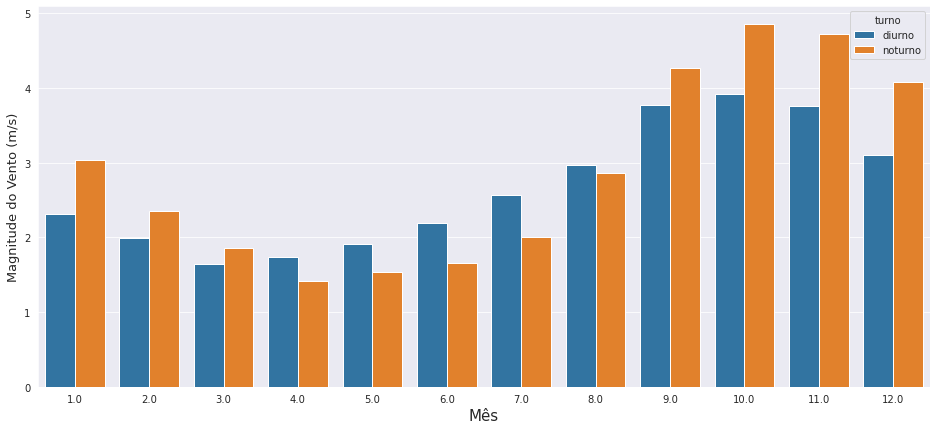

In [121]:
plot_bar('Quixeramobim')

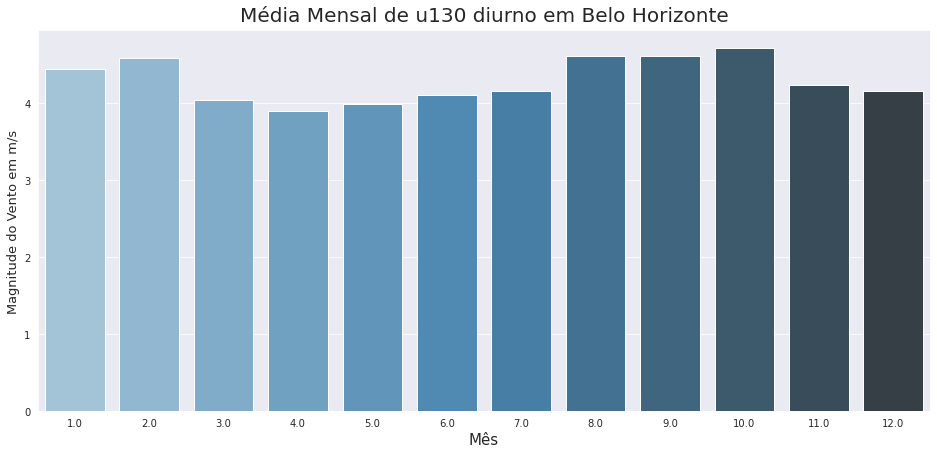

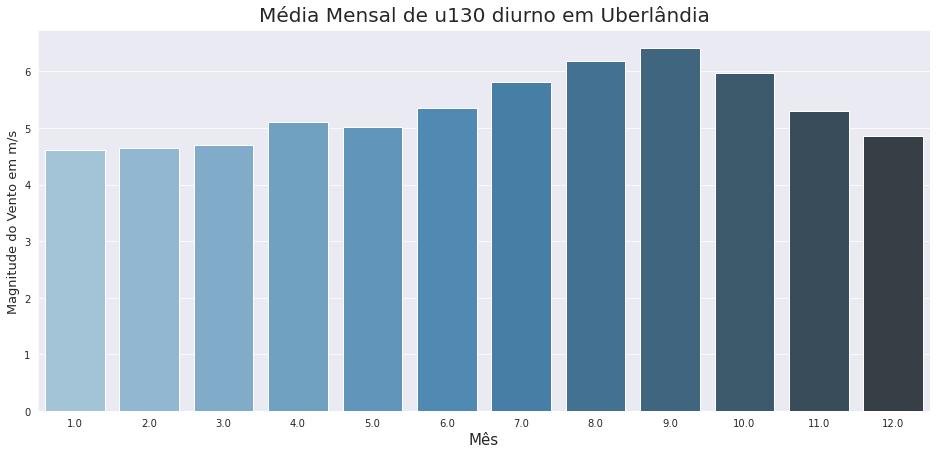

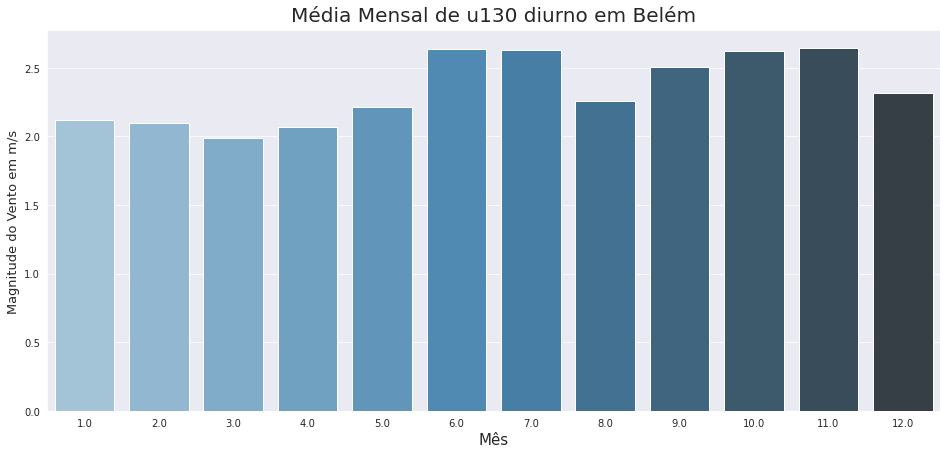

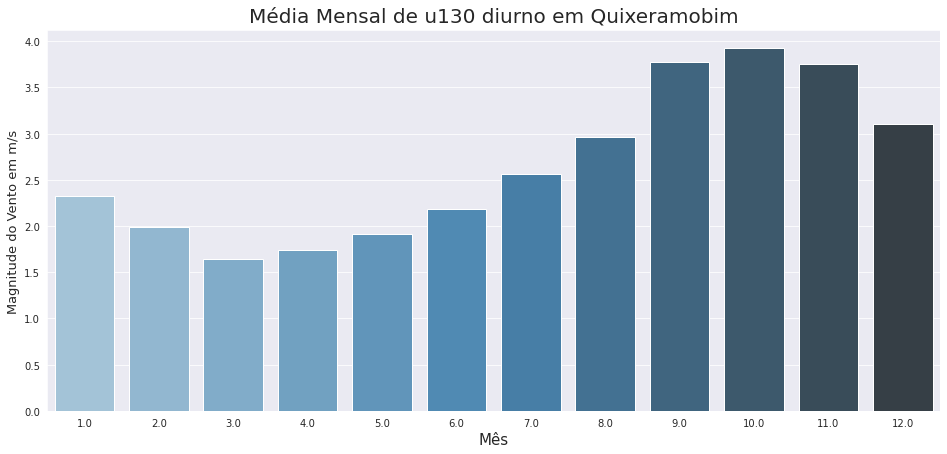

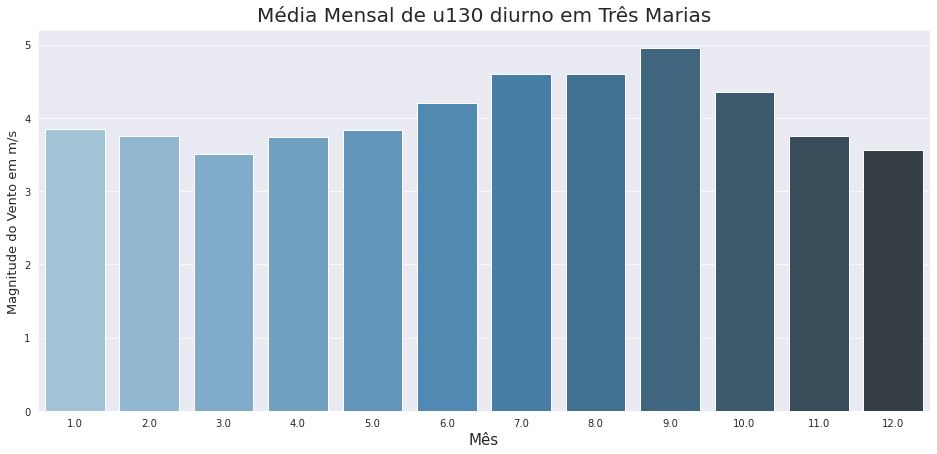

In [27]:
for cada in df_list:
    plot_bar(cada, 'diurno')

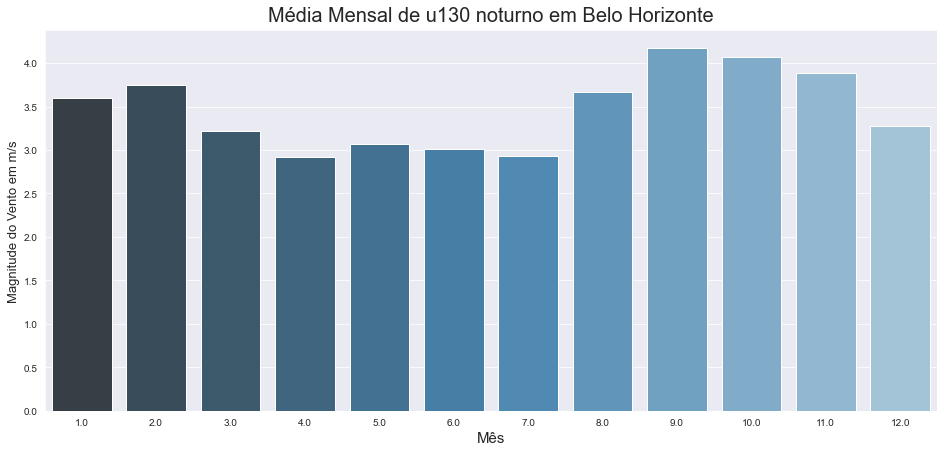

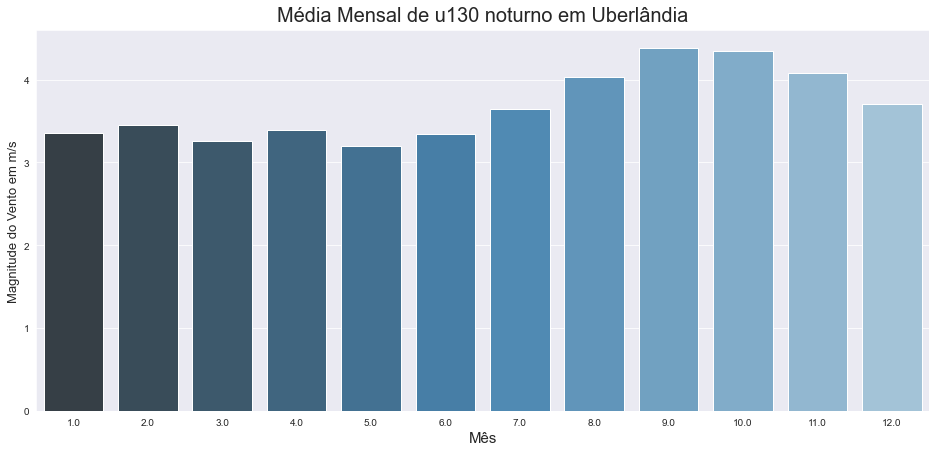

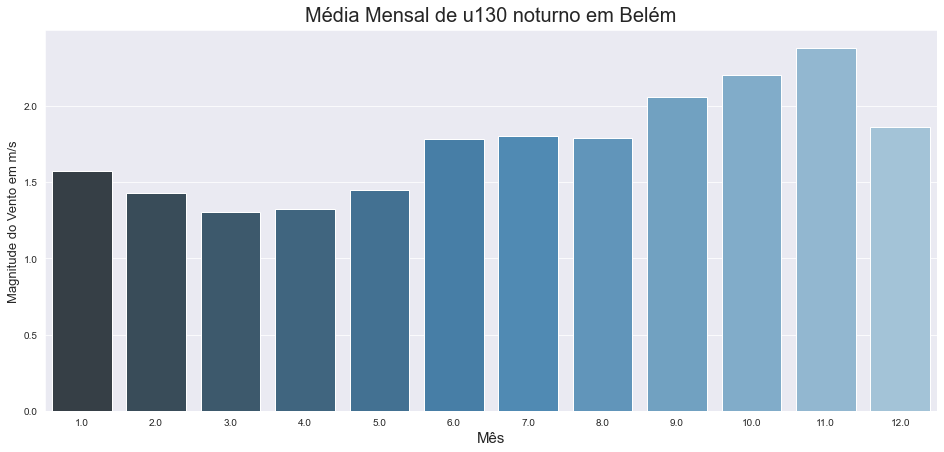

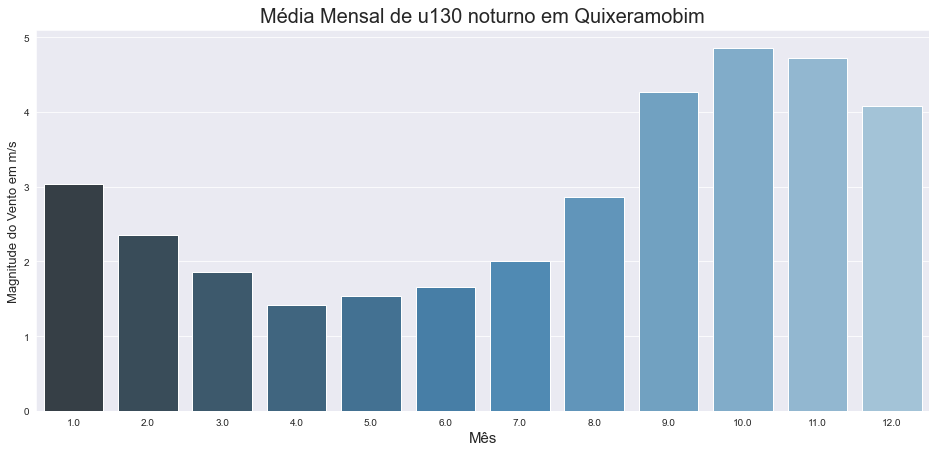

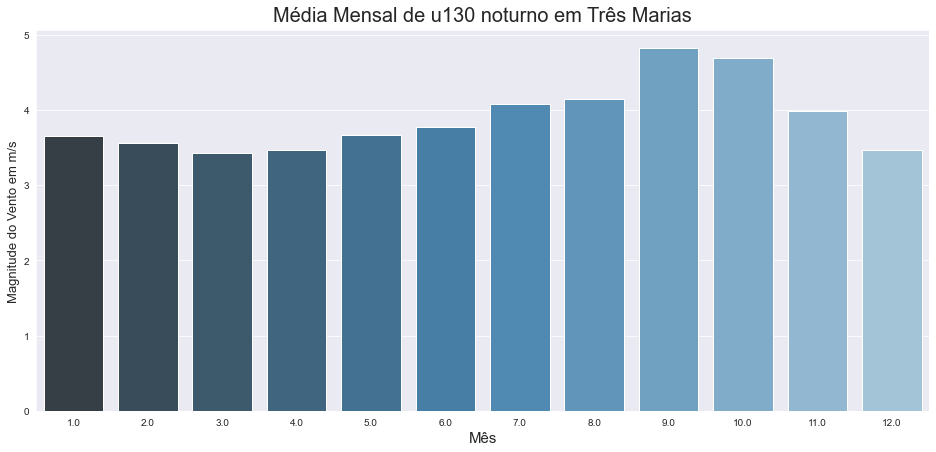

In [164]:
for cada in df_list:
    plot_bar(cada, 'noturno')